In [1]:
import os
import re
import math
from pathlib import Path

import numpy as np
import pandas as pd

In [2]:
# Add utils to this notebook's sys path
import sys; sys.path.insert(0, str(Path("../scripts/").resolve()))
import utils

## Constants

In [3]:
### ACS datasets:
# DATASET = "ACSIncome"
# DATASET = "ACSEmployment"
# DATASET = "ACSTravelTime"
# DATASET = "ACSPublicCoverage"
# DATASET = "ACSMobility"

### Others:
DATASET = "MEPS"

In [4]:
# Number of trials that we want to use
N_TRIALS = 50
SEED = 21

In [5]:
# SHOW_DATA_TYPE = "validation"         # Data to show in plots
SHOW_DATA_TYPE = "test"               # Data to show in plots
SELECT_ON_DATA_TYPE = "validation"    # Data to use for model selection

PERFORMANCE_METRIC = "accuracy"
DISPARITY_METRIC = "equal_odds_diff"

## Load aggregated results

In [6]:
home_results_dir = Path("../results").resolve()

**Note**: switch commented lines in the following cell to use results for experiment with 2 or 4 sensitive groups.

In [7]:
if "acs" in DATASET.lower():
    home_results_dir /= "ACS_T5.6-results_train=0.6_test=0.2_validation=0.2_max-groups=4_2023-09-06"
    # home_results_dir /= "ACS_T5.6-results_train=0.6_test=0.2_validation=0.2_max-groups=2_2023-09-06"

elif DATASET == "MEPS":
    home_results_dir /= "MEPS_T5.6-results_train_23380_test_15675_val_10020_3-groups_2023-09-08"

else:
    print(f"Couldn't find results file for dataset '{DATASET}'")

In [8]:
# Path to aggregated results file
task_df_path = home_results_dir / f"{DATASET}.{N_TRIALS}-trials.csv"

print(f"Loading experiments for {DATASET} dataset from '{task_df_path}'\n")
task_df = pd.read_csv(task_df_path, index_col=0, keep_default_na=False)

print(f"task_df.shape={task_df.shape}")
task_df.head(3)

Loading experiments for MEPS dataset from '/lustre/home/acruz/t5.6-supp-materials/results/MEPS_T5.6-results_train_23380_test_15675_val_10020_3-groups_2023-09-08/MEPS.50-trials.csv'

task_df.shape=(1000, 767)


,original_test_accuracy,original_test_accuracy_diff,original_test_accuracy_diff_high-percentile,original_test_accuracy_diff_low-percentile,original_test_accuracy_diff_mean,original_test_accuracy_diff_stdev,original_test_accuracy_high-percentile,original_test_accuracy_low-percentile,original_test_accuracy_mean,original_test_accuracy_ratio,...,one_hot,base_model,meta_model,preprocessor_model,results_dir_path,results_json_path,model_pkl_path,unadjusted_pkl_path,expID,intervention
MEPS_base=lightgbm_meta=None_preprocessor=fairlearn-correlation-remover_one-hot=True_seed=716967289_hash=ada0a818_2023.09.08-13.59,0.860797,0.117617,0.130927,0.104130,0.117946,0.006997,0.866285,0.856013,0.860888,0.871297,...,True,GBM,None,CR,/lustre/fast/fast/acruz/MEPS_T5.6-results_trai...,/lustre/fast/fast/acruz/MEPS_T5.6-results_trai...,/lustre/fast/fast/acruz/MEPS_T5.6-results_trai...,/lustre/fast/fast/acruz/MEPS_T5.6-results_trai...,"GBM, CR",CR
MEPS_base=logistic-regression_meta=fairlearn-GS_equal-odds-constraint_preprocessor=None_one-hot=True_seed=531542815_hash=457946cf_2023.09.08-14.37,0.839745,0.131426,0.144240,0.118650,0.131156,0.006722,0.846062,0.833477,0.839903,0.854686,...,True,LR,GS,None,/lustre/fast/fast/acruz/MEPS_T5.6-results_trai...,/lustre/fast/fast/acruz/MEPS_T5.6-results_trai...,/lustre/fast/fast/acruz/MEPS_T5.6-results_trai...,/lustre/fast/fast/acruz/MEPS_T5.6-results_trai...,"LR, GS",GS
MEPS_base=lightgbm_meta=fairlearn-EG_equal-odds-constraint_preprocessor=None_one-hot=False_seed=575956225_hash=a77b0611_2023.09.08-14.11,0.844530,0.111712,0.124741,0.099297,0.111979,0.006788,0.849834,0.838777,0.844473,0.874601,...,False,GBM,EG,None,/lustre/fast/fast/acruz/MEPS_T5.6-results_trai...,/lustre/fast/fast/acruz/MEPS_T5.6-results_trai...,/lustre/fast/fast/acruz/MEPS_T5.6-results_trai...,/lustre/fast/fast/acruz/MEPS_T5.6-results_trai...,"GBM, EG",EG


In [9]:
# Images directory
imgs_dir = Path("../imgs").resolve() / home_results_dir.name
imgs_dir.mkdir(exist_ok=True)

def save_fig(fig, fig_name: str, data_type: str = SHOW_DATA_TYPE):
    fig_name = f"{DATASET}.{fig_name}.{data_type}"
    fig.savefig(imgs_dir / f"{fig_name}.png", bbox_inches="tight")
    fig.savefig(imgs_dir / f"{fig_name}.pdf", bbox_inches="tight")

# Gather wall-clock times for preprocessing and postprocessing

In [10]:
curr_folder = task_df["results_dir_path"].iloc[0]

print(curr_folder)
for f in Path(curr_folder).iterdir():
    print(f.name)

/lustre/fast/fast/acruz/MEPS_T5.6-results_train_23380_test_15675_val_10020_3-groups_2023-09-08/MEPS_base=lightgbm_meta=None_preprocessor=fairlearn-correlation-remover_one-hot=True_seed=716967289_hash=ada0a818_2023.09.08-13.59.12
time-to-fit-postprocessor.txt
sampled-preprocessor-kwargs.json
model-predictions.test.npy
all_results.json
model-predictions.train.npy
model-predictions.validation.npy
sampled-model-kwargs.json
cmd-line-args.json
time-to-fit-original-model.txt
time-to-fit-preprocessor.txt


In [11]:
import re
from collections import defaultdict

model_time_file = "time-to-fit-original-model.txt"

preprocessor_time_file = "time-to-fit-preprocessor.txt"
postprocessor_time_file = "time-to-fit-postprocessor.txt"


def parse_time_to_fit_file(path: str | Path) -> dict:
    wallclock_regex = r"wall-clock time: (?P<time>\d+([.]\d*)?)"
    processtime_regex = r"process time: (?P<time>\d+([.]\d*)?)"
    
    with open(path, "r") as f_in:
        whole_file = f_in.read()

    wc_match = re.search(wallclock_regex, whole_file)
    pc_match = re.search(processtime_regex, whole_file)

    if not wc_match or not pc_match:
        logging.error(f"Failed to match contents of `TimeIt` file at {path}")
        return {}

    return {
        "wall-clock_time": float(wc_match.group("time")),
        "process_time": float(pc_match.group("time")),
    }

In [12]:
def aggregate_time_results(results_df, save_path: str | Path = None) -> pd.DataFrame:
    """Loads the "time-to-fit" data from disk, for each experiment in `results_df`.
    """

    TIME_TYPE = "process_time"
    # TIME_TYPE = "wall-clock_time"

    model_times = defaultdict(list)
    preproc_times = defaultdict(list)
    postproc_times = defaultdict(list)

    agg_data = list()

    from tqdm.auto import tqdm
    for idx, row in tqdm(results_df.iterrows(), total=len(results_df)):
        exp_dir = Path(row.results_dir_path)

        model_time_path = exp_dir / model_time_file
        curr_model_time = parse_time_to_fit_file(model_time_path)
        model_times[row.expID].append(curr_model_time)

        postproc_time_path = exp_dir / postprocessor_time_file
        curr_postproc_time = parse_time_to_fit_file(postproc_time_path)
        postproc_times[row.expID].append(curr_postproc_time)

        preproc_time_path = exp_dir / preprocessor_time_file
        curr_preproc_time = parse_time_to_fit_file(preproc_time_path) if preproc_time_path.exists() else None
        preproc_times[row.expID].append(curr_preproc_time)

        agg_data.append(dict(
            index=idx,
            dataset=row.dataset,
            expID=row.expID,

            base_model=row.base_model,
            meta_model=row.meta_model,
            preproc_model=row.preprocessor_model,
            results_dir_path=row.results_dir_path,

            model_time=curr_model_time[TIME_TYPE],
            postproc_time=curr_postproc_time[TIME_TYPE],
            preproc_time=curr_preproc_time[TIME_TYPE] if curr_preproc_time else None,
        ))

    # Create DF
    times_df = pd.DataFrame(agg_data)

    if save_path is not None:
        times_df.to_csv(save_path, header=True, index=False)
        print(f"Saving time-to-fit information to '{save_path}'")

    return times_df

In [13]:
times_df_save_path = task_df_path.with_suffix(".time-to-fit.csv")

# Check if file exists and, if so, load resutls from disk
if times_df_save_path.exists():
    times_df = pd.read_csv(times_df_save_path, index_col=0, keep_default_na=True)

# Else, gather results from scattered directories
else:
    times_df = aggregate_time_results(task_df, save_path=times_df_save_path)

In [14]:
# Create new useful columns
times_df["interv_time"] = times_df["model_time"].where(
    cond=times_df["preproc_time"].isna(),
    other=times_df["preproc_time"],
)

# Total time for each row
times_df["total_interv_time"] = [
    (
        row.model_time + 
        (row.preproc_time if not math.isnan(row.preproc_time) else 0)
    )
    for _idx, row in times_df.iterrows()
]

# Analyze results

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
sns.set(style="whitegrid", palette="colorblind", rc={"grid.linestyle": "--"})
sns_whitegrid_style = sns.axes_style()

---
Plot parameters:
- order of labels (algorithm type and intervention type);
- color and marker style for each label;
- legend kwargs, scatterplot kwargs, figure kwargs, ...

In [16]:
base_model_labels_sort = task_df["base_model"].unique().tolist()
base_model_labels_sort = sorted(base_model_labels_sort)

base_model_to_color_map = dict(zip(base_model_labels_sort, sns.color_palette("colorblind")))
palette = [base_model_to_color_map[bm] for bm in base_model_labels_sort]

print(f"Order of base model labels: {base_model_labels_sort}")

Order of base model labels: ['GBM', 'LR', 'NN', 'RF']


In [17]:
intervention_labels_sort = sorted(task_df["intervention"].unique().tolist())

# Set "None" (no intervention) in the beginning and "FairGBM" at the end (as it only applies to GBM)
intervention_labels_sort.remove("None")
intervention_labels_sort.remove("FairGBM")
intervention_labels_sort = ["None"] + intervention_labels_sort + ["FairGBM"]

intervention_labels_markers = ["o", (4, 0, 0), "P", "X", (5, 1, 0), "^"]
intervention_to_marker_map = dict(zip(intervention_labels_sort, intervention_labels_markers))

print(intervention_labels_sort)

['None', 'CR', 'EG', 'GS', 'LFR', 'FairGBM']


In [18]:
def compute_expID_sort_key(expID: str) -> int:

    # Sort by base_model first
    base_key = [
        idx 
        for idx, bmodel in enumerate(base_model_labels_sort) 
        if bmodel in expID
    ][0]
    
    # Then sort by intervention
    interv_key = [
        idx
        for idx, interv in enumerate(intervention_labels_sort)
        if interv in expID
    ]

    # Put unconstrained methods first
    interv_key = interv_key[0] if interv_key else -1

    return base_key * 100 + interv_key

exp_id_labels_sort = sorted(
    task_df["expID"].unique().tolist(),
    key=compute_expID_sort_key,
)

print(exp_id_labels_sort)

['GBM', 'GBM, CR', 'GBM, EG', 'GBM, GS', 'GBM, LFR', 'FairGBM', 'LR', 'LR, CR', 'LR, EG', 'LR, GS', 'LR, LFR', 'NN', 'NN, CR', 'NN, EG', 'NN, LFR', 'RF', 'RF, CR', 'RF, EG', 'RF, GS', 'RF, LFR']


---
---
# Bar plot with time to fit each model (w/ different combinations)

In [19]:
def bootstrap_mean(data, ci_pct=95, n_boot=1000):
    """Compute confidence intervals for the mean of the data
    using bootstrapping.
    """
    
    rng = np.random.default_rng(SEED)
    bootstrap_results = []

    for _ in range(n_boot):

        bootstrap_sample = rng.choice(data, size=len(data), replace=True)
        curr_boot_result = np.mean(bootstrap_sample)
        bootstrap_results.append(curr_boot_result)
    
    ci_lo, ci_hi = (100 - ci_pct) / 2, ci_pct + (100 - ci_pct) / 2
    lo_val, med_val, hi_val = np.percentile(bootstrap_results, [ci_lo, 50, ci_hi])
    return {
        f"{ci_lo:.1f}": lo_val,
        f"{50:.1f}": med_val,
        f"{ci_hi:.1f}": hi_val,
    }

Compute time-to-fit for each separate `expID`:

In [20]:
time_to_fit_per_expID = {}

for expID in times_df["expID"].unique():
    time_to_fit_per_expID[expID] = (
        bootstrap_mean(times_df[times_df["expID"] == expID]["total_interv_time"])
    )

time_to_fit_per_expID = pd.DataFrame(time_to_fit_per_expID).transpose()

Compute time-to-fit unprocessing (the postprocessing adjustment) on top of each different `expID`:

In [21]:
postproc_time_per_expID = {}

for expID in times_df["expID"].unique():
    postproc_time_per_expID[expID] = (
        bootstrap_mean(times_df[times_df["expID"] == expID]["postproc_time"])
    )

postproc_time_per_expID = pd.DataFrame(postproc_time_per_expID).transpose()

In [22]:
time_to_fit_and_postproc_per_expID = time_to_fit_per_expID.join(
    other=postproc_time_per_expID,
    how="left",
    rsuffix="_postproc",
)
time_to_fit_and_postproc_per_expID

,2.5,50.0,97.5,2.5_postproc,50.0_postproc,97.5_postproc
"GBM, CR",3.705378,5.49827,7.697709,0.351059,0.52926,0.743419
"LR, GS",29.151948,35.46174,42.705036,0.090499,0.09224,0.094180
"GBM, EG",136.314594,186.15593,250.844413,3.471001,4.78407,6.462975
NN,21.279800,31.08836,43.899316,0.232554,0.24700,0.262961
"NN, CR",18.503201,30.03336,44.039306,0.215897,0.23003,0.245862
LR,0.927794,1.14880,1.406624,0.099759,0.10274,0.106401
GBM,2.366313,3.32028,4.450469,0.686575,0.93010,1.241801
"LR, LFR",17.828441,20.04215,22.400576,0.081019,0.08356,0.085920
FairGBM,3.466495,4.69692,6.259148,0.416673,0.55329,0.716560
"RF, CR",14.503063,20.81179,28.282608,0.778773,1.05918,1.401558


---

In [23]:
BASE_MODEL = "GBM"

base_model_filter = ["gbm" in idx.lower() for idx in time_to_fit_and_postproc_per_expID.index]

plot_df = time_to_fit_and_postproc_per_expID[base_model_filter].sort_values(by="50.0")
plot_df

,2.5,50.0,97.5,2.5_postproc,50.0_postproc,97.5_postproc
GBM,2.366313,3.32028,4.450469,0.686575,0.93010,1.241801
FairGBM,3.466495,4.69692,6.259148,0.416673,0.55329,0.716560
"GBM, CR",3.705378,5.49827,7.697709,0.351059,0.52926,0.743419
"GBM, LFR",24.504666,28.58216,33.608189,0.618580,0.84432,1.137887
"GBM, GS",82.206960,116.05049,161.707854,0.920628,1.34200,1.955338
"GBM, EG",136.314594,186.15593,250.844413,3.471001,4.78407,6.462975


In [24]:
plot_df.index

Index(['GBM', 'FairGBM', 'GBM, CR', 'GBM, LFR', 'GBM, GS', 'GBM, EG'], dtype='object')

In [25]:
full_palette = sns.color_palette(palette="colorblind", n_colors=6, desat=0.75)
full_palette

[(0.09068627450980393, 0.42598039215686273, 0.6112745098039215),
 (0.7642156862745098, 0.5318627450980391, 0.12598039215686285),
 (0.084313725490196, 0.5431372549019609, 0.41666666666666674),
 (0.7308823529411765, 0.3808823529411765, 0.10441176470588232),
 (0.7588235294117647, 0.5117647058823529, 0.7117647058823526),
 (0.7406862745098038, 0.5730392156862745, 0.4318627450980391)]

In [26]:
exp_id_to_color_map = {
    "GBM": full_palette[0],
    "GBM, CR": full_palette[1],
    "GBM, EG": full_palette[2],
    "GBM, GS": full_palette[3],
    "GBM, LFR": full_palette[4],
    "FairGBM": full_palette[5],
    
}

In [27]:
def expID_to_label(expID):

    if expID == "FairGBM":
        return "FGBM"
    
    elif "," in expID:
        return expID[expID.find(", ") + 2:]
    
    else:
        return expID

In [28]:
task_to_ylim = {
    # ACS datasets w/ 4 groups
    "ACSIncome": (1e2, 3.5e4),
    "ACSEmployment": (1e2, 7e4),
    "ACSMobility": (1e1, 4e4),
    "ACSPublicCoverage": (1e2, 3.5e4),
    "ACSTravelTime": (1e2, 3.5e4),
    
    # ACS datasets w/ 2 groups
    "ACSIncome_2-groups": (1e2, 4.5e4),
    "ACSEmployment_2-groups": (1e2, 7e4),
    "ACSMobility_2-groups": (1e1, 4e4),
    "ACSPublicCoverage_2-groups": (5e1, 4.5e4),
    "ACSTravelTime_2-groups": (1e2, 3.5e4),

    # MEPS dataset
    "MEPS": (1e0, 3e2),
}

ylim = task_to_ylim[DATASET + ("_2-groups" if "max-groups=2" in home_results_dir.name else "")]
ylim

(1.0, 300.0)

/tmp/ipykernel_427110/2057261231.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([expID_to_label(eid) for eid in plot_df.index])


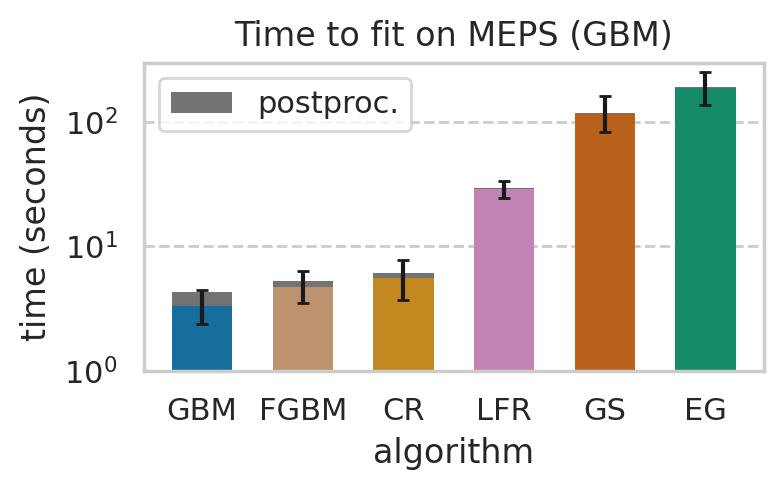

In [29]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=200)

# Err. as per confidence intervals
err_lo = plot_df["50.0"] - plot_df["2.5"]
err_hi = plot_df["97.5"] - plot_df["50.0"]

# Plot intervention times
b1 = ax.bar(
    plot_df.index, plot_df["50.0"],
    color=[exp_id_to_color_map[eid] for eid in plot_df.index],
    width=0.6,
    yerr=np.vstack((err_lo.to_numpy(), err_hi.to_numpy())),
    capsize=2,
    capstyle="round",
    lw=0,
)

# Plot postprocessing times
postproc_bar_color = (0.45, 0.45, 0.45)

b2 = ax.bar(
    plot_df.index, plot_df["50.0_postproc"],
    label="postproc.",
    bottom=plot_df["50.0"],
    color=postproc_bar_color,
    width=0.6,
    lw=0
#     linewidth=5,
#     edgecolor=postproc_bar_color,
)


ax.set_yscale("log")
ax.set_xticklabels([expID_to_label(eid) for eid in plot_df.index])
ax.set_ylim(ylim)

ax.legend(loc="upper left")

plt.ylabel("time (seconds)")
plt.xlabel("algorithm")

ax.grid(visible=False, axis="x")
plt.title(f"Time to fit on {DATASET} ({BASE_MODEL})")

figname = f"time-to-fit-interventions.{BASE_MODEL}.plt"
save_fig(fig, figname)

plt.show()

---